In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_train = pd.read_csv('train.csv')
X, y = df_train.drop(['SalePrice', 'Id'], axis=1), df_train.SalePrice
df_test = pd.read_csv('test.csv')

<Axes: xlabel='MSSubClass'>

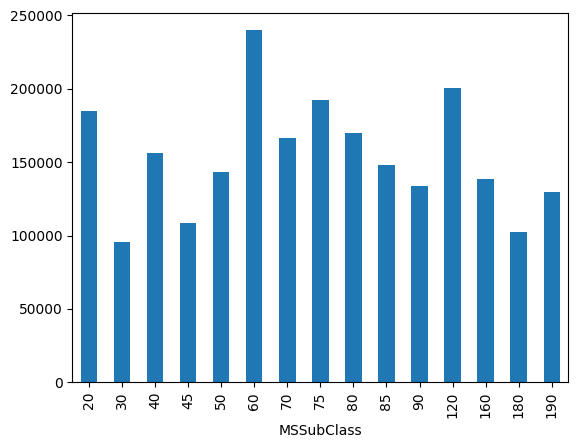

In [4]:
df_train.groupby('MSSubClass', dropna=False)['SalePrice'].mean().plot(kind='bar')

### Изучу сам датасет и устройство категориальных и вещественных признаков:

In [5]:
X.shape

(1460, 79)

In [6]:
pd.value_counts(X.dtypes)

object     43
int64      33
float64     3
dtype: int64

In [7]:
X.select_dtypes(exclude='number').head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [8]:
X.describe(exclude='number')

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


Некоторые признаки содержат очень много пустых значений, на что нужно будет обратить внимание во время их обработки.

При изучении описании датасета можно выяснить, что во многих столбцах пустые значения означают не отсутствие информации, а отсутствие того или иного "критерия", который влияет на цену жилья.

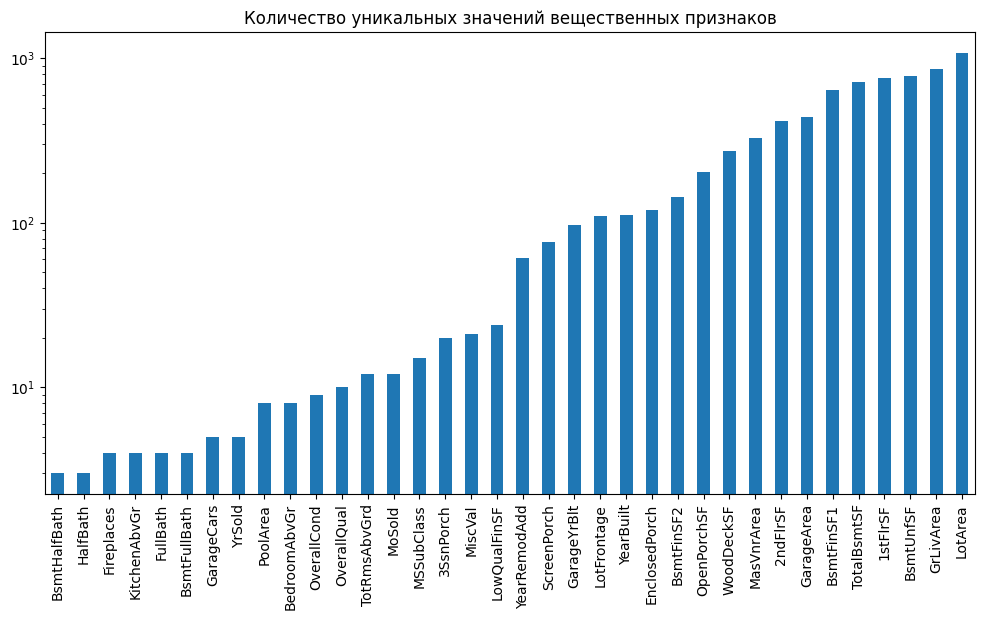

In [9]:
number_of_unique_values = X.select_dtypes(include="number").nunique().sort_values()

plt.figure(figsize=(12, 6))
number_of_unique_values.plot(kind='bar', logy=True)
plt.title('Количество уникальных значений вещественных признаков');

При помощи столбчатой диаграммы возможно оценить, какие признаки могут являться порядковыми, а какие имеют непрерывное распределение.

### Посмотрим на пропущенные значения:

In [10]:
isnull = X.isnull().sum()
print(isnull[isnull > 0])

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


In [11]:
isnull_test = df_test.isnull().sum()
print(isnull_test[isnull_test > 0])

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64


In [12]:
df_test[['GarageType', 'GarageCars', 'GarageArea', 'GarageQual']].iloc[1116, :]

GarageType    Detchd
GarageCars       NaN
GarageArea       NaN
GarageQual       NaN
Name: 1116, dtype: object

Выше видим, что в тесте некоторые пустые значения действительно означают отсутствие информации. Однако речь тут идет о парочке объектов, которые не будут оказывать сильного влияния на итоговое качество.

Многие из этих признаков (начинающиеся на 'Bsmt', связанные с гаражом, бассейном и т.п.) имеют нулевые значения, означающие отсутствие какого-то элемента собственности. Соответствующие им вещественные признаки тоже имеют пустые значения на этих объектах (скорее всего, будет логично заменить 0).

Кроме того, пустые значения, которые не встречаются в трейне, есть в тесте. Обычно речь идет о единичных значениях. В этих признаках возможно появление значения 0 (если речь, например, идет о количестве ванных комнат), поэтому буду заменять их на 0.

In [13]:
#категориальные признаки, NaN в которых можно заменить на отсутствие чего-либо
#в соответствии с описанием датасета
empty_to_no = [
    'Alley',
    'MasVnrType',
    'BsmtQual',
    'BsmtExposure',
    'BsmtFinType1',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PoolQC',
    'Fence',
    'MiscFeature',
]

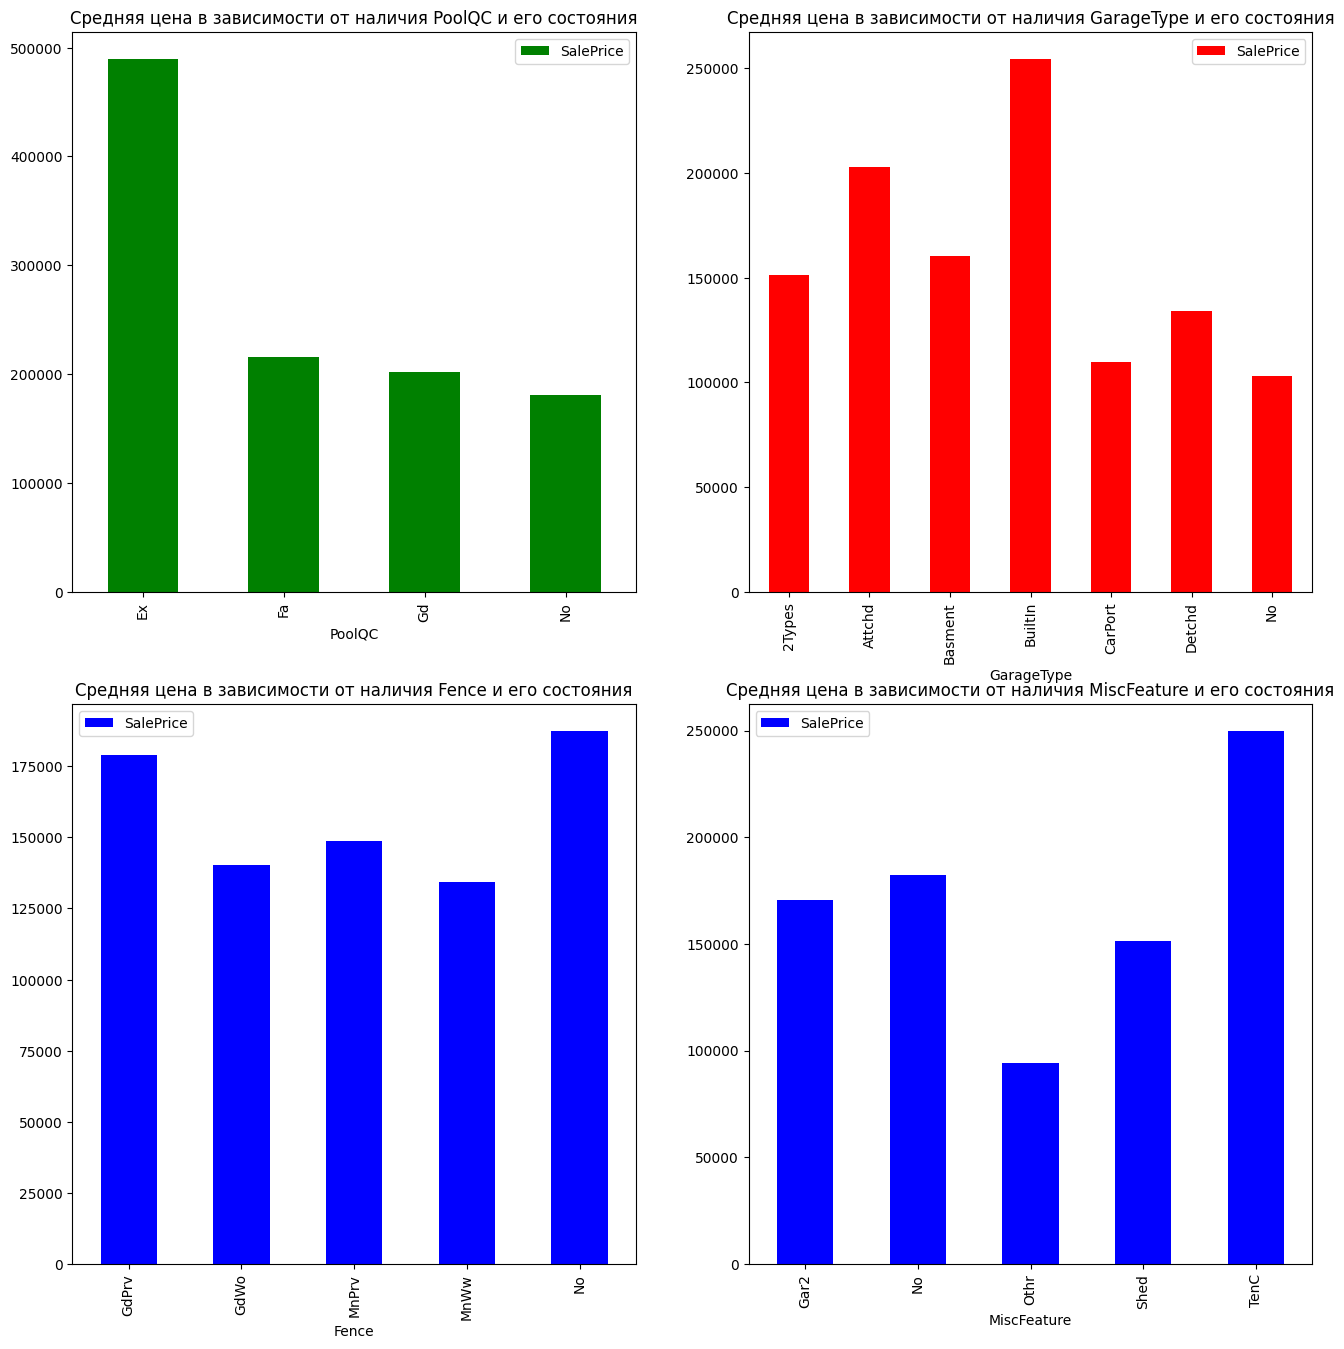

In [14]:
_, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

def draw_no_cat(cat: str, axis, color: str='blue'):
  title = 'Средняя цена в зависимости от наличия ' + cat + ' и его состояния'
  df_train[[cat, 'SalePrice']]\
        .fillna('No').groupby(cat)\
        .mean()\
        .plot(kind='bar', title=title, ax=axis, color=color)

draw_no_cat('PoolQC', axes[0, 0], 'green')
draw_no_cat('GarageType', axes[0, 1], 'red')
draw_no_cat('Fence', axes[1, 0])
draw_no_cat('MiscFeature', axes[1, 1])

Видим, что факт наличия того или иного атрибута действительно влияет на итоговую цену.

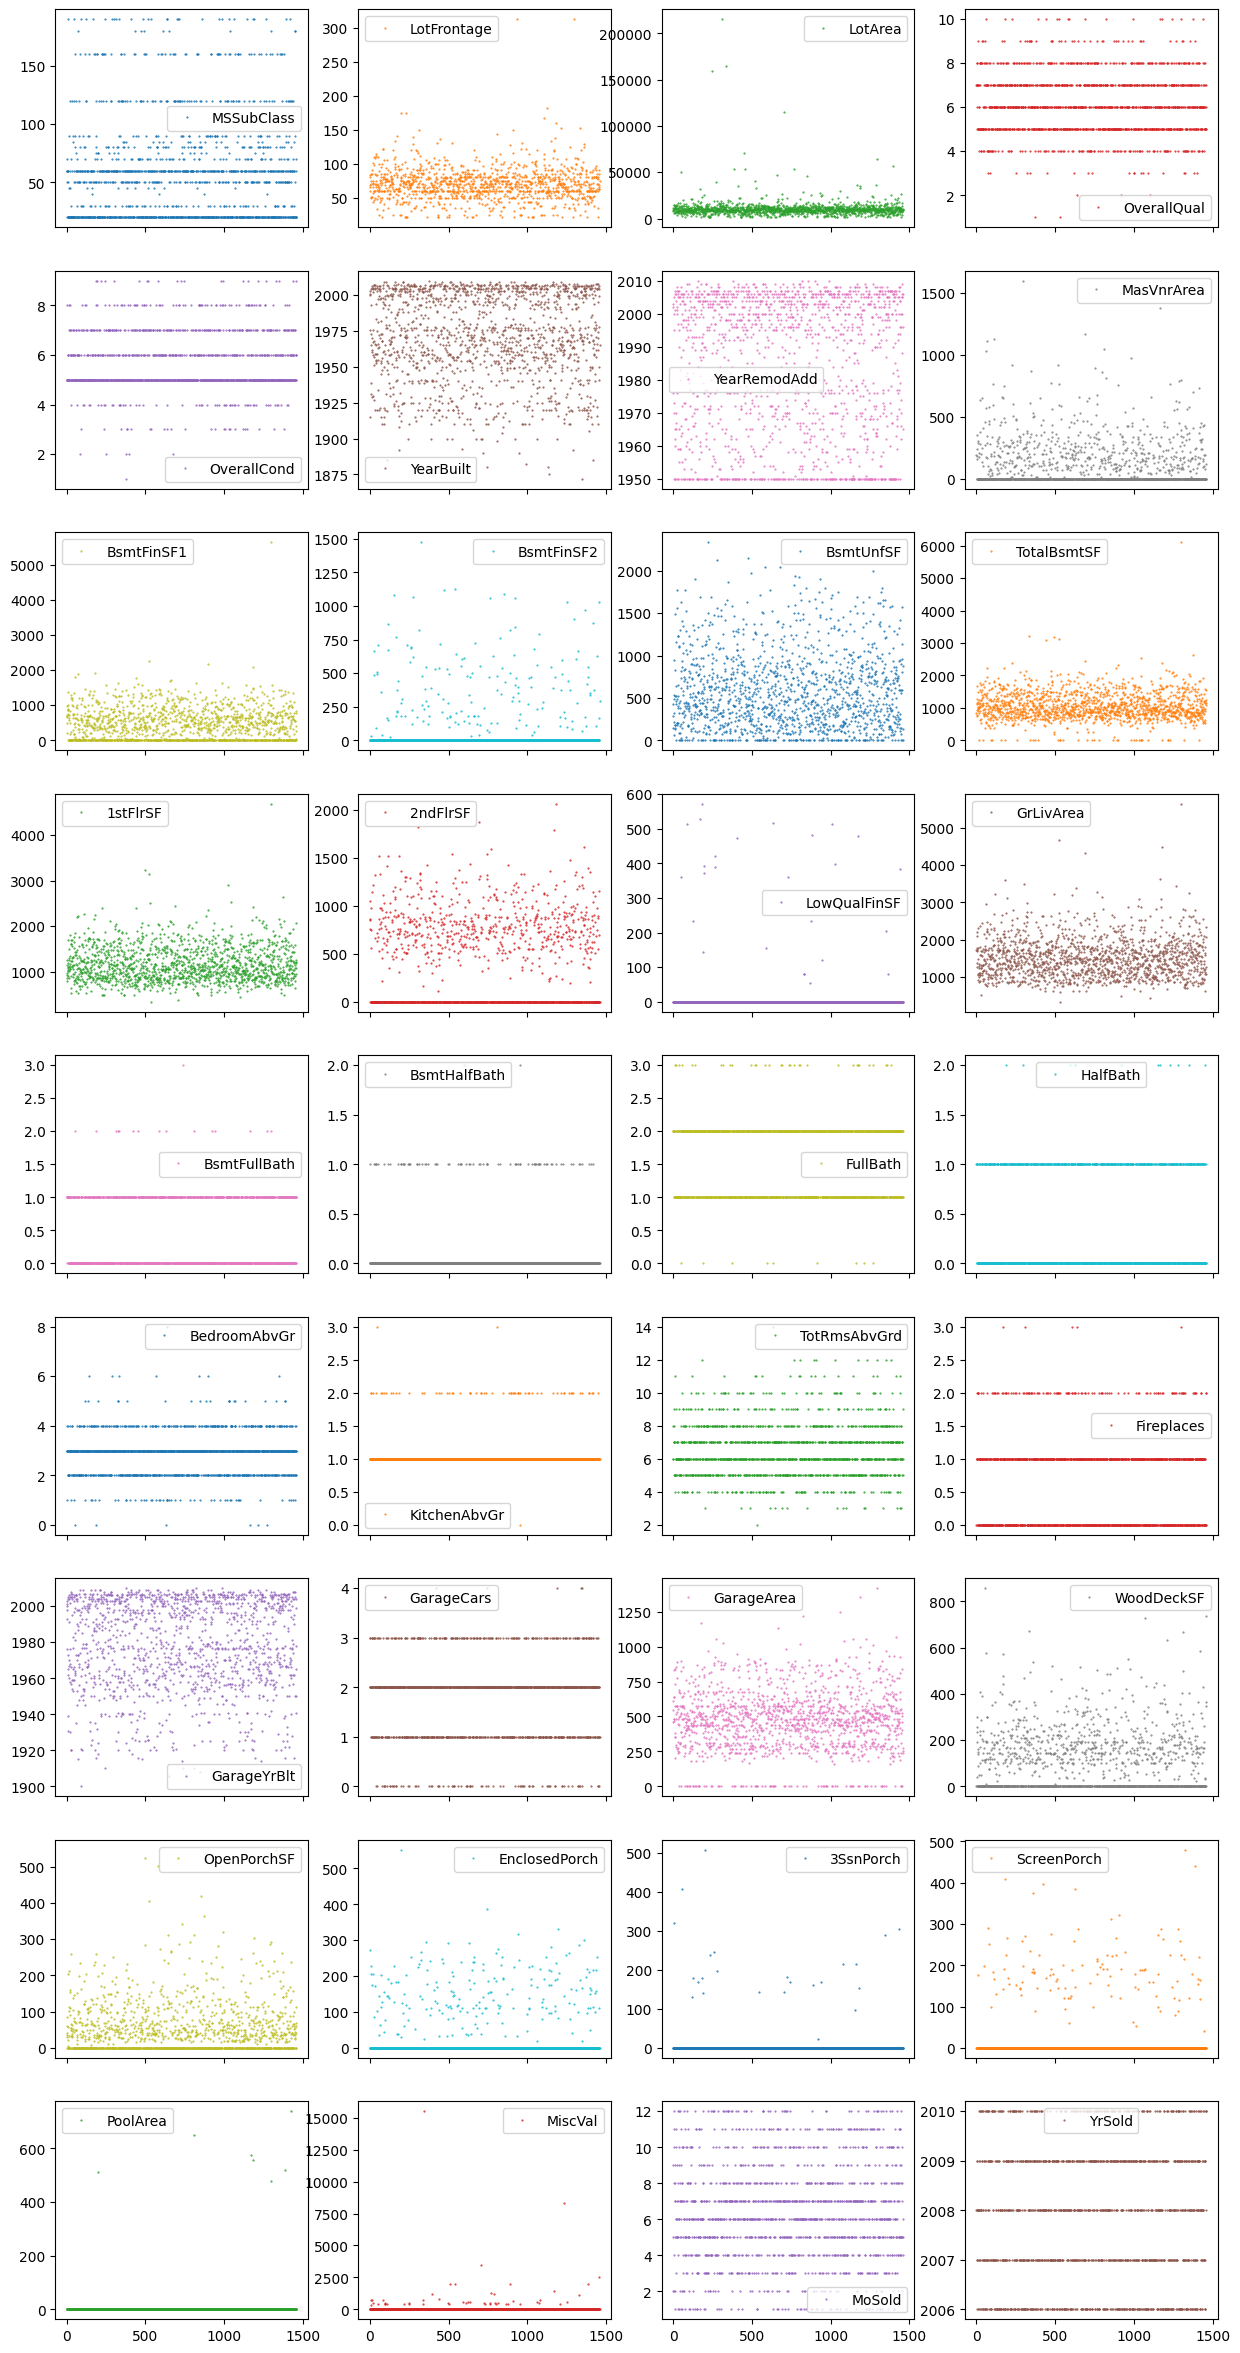

In [15]:
X.plot(lw=0, marker=".", subplots=True, layout=(-1, 4),
          figsize=(15, 30), markersize=1);

Оформление графиков подглядел здесь: https://miykael.github.io/blog/2022/advanced_eda/

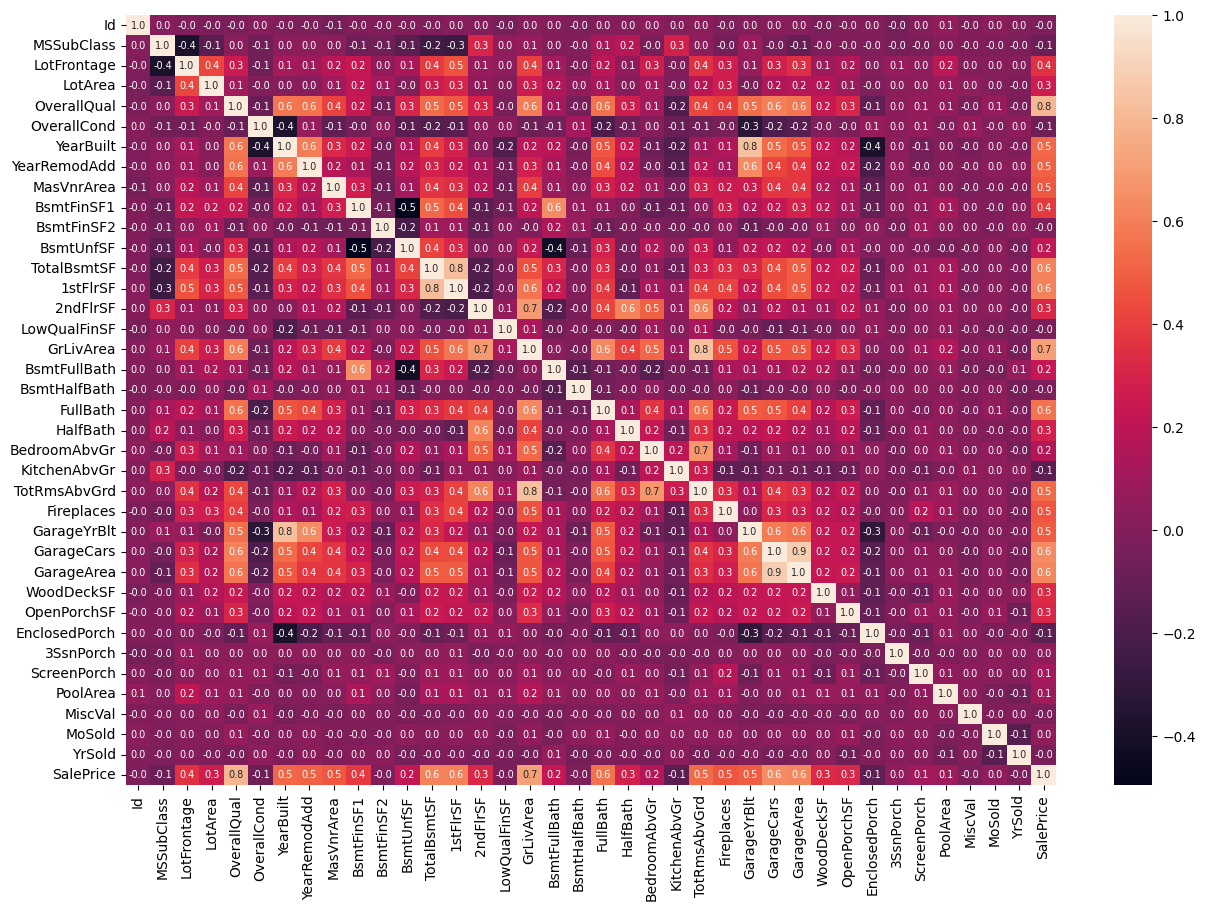

In [16]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df_train.corr(numeric_only=True), annot=True, annot_kws={'fontsize':7}, fmt=".1f");

Между некоторыми парами признаков наблюдается линейная зависимость. Посмотрим на эти признаки по отдельности:

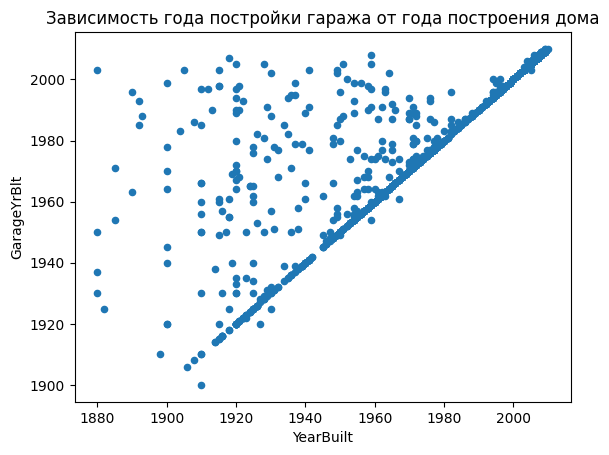

In [17]:
title = 'Зависимость года постройки гаража от года построения дома'
df_train.plot(kind='scatter', x='YearBuilt', y='GarageYrBlt', title=title);

Видим довольно сильную линейную зависимость между этими признаками, однако, можем заметить, что на многих объектах гараж был построен позже здания, что влияет на таргет!

Предложенное мной решение: переведу год постройки гаража в бинарную переменную. Если его год меньше или равен году основания здания, то проставлю значение 0, в ином случае – 1.

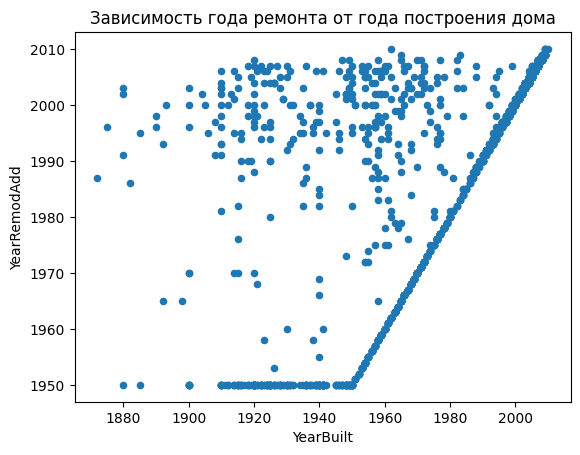

In [18]:
title = 'Зависимость года ремонта от года построения дома'
df_train.plot(kind='scatter', x='YearBuilt', y='YearRemodAdd', title=title);

Предлагаю бинаризовать этот признак по той же схеме, что описана выше.

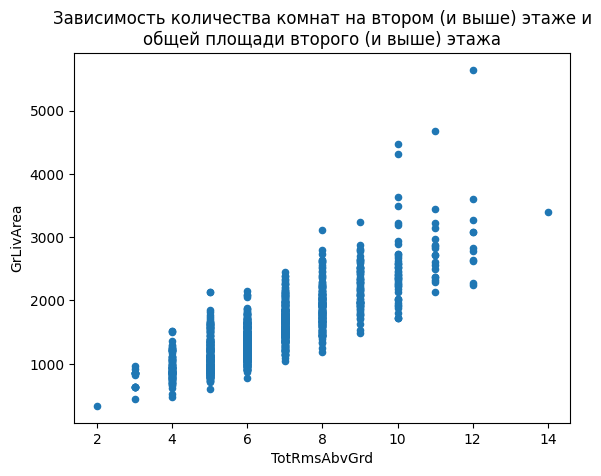

In [19]:
title = 'Зависимость количества комнат на втором (и выше) этаже и\n\
общей площади второго (и выше) этажа'
df_train.plot(kind='scatter', x='TotRmsAbvGrd', y='GrLivArea', title=title);

Признаки линейно зависимы, есть только несколько точек на большом числе комнат, где площадь резко возрастает. Сильнее на таргет (более скоррелированный признак) влияет площадь, поэтому признак TotRmsAbvGrd лучше убрать (кроме того, есть признак, отвечающий за количество спальных комнат на втором этаже).

Сильно скоррелированы признаки GarageCars и GarageArea, отвечающие за то, сколько автомобилей помещается в гараж и площадь гаража (то есть по сути, эти признаки обозначают одно и тоже, но в разных величинах). Оставлю только GarageCars.

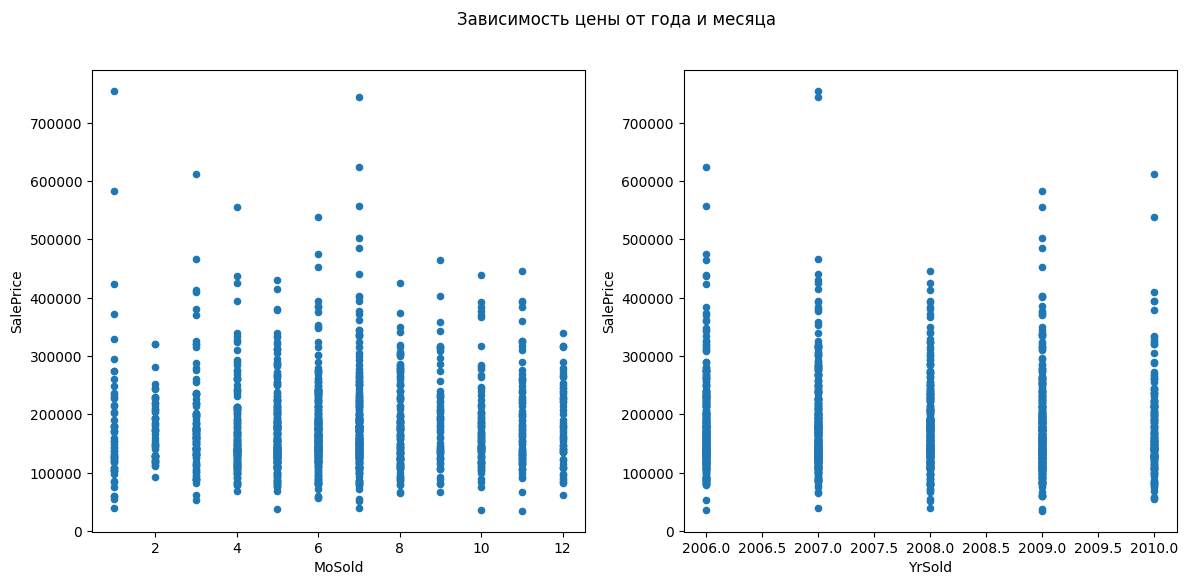

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
fig.suptitle('Зависимость цены от года и месяца')

df_train.plot(kind='scatter', x='MoSold', y='SalePrice', ax=ax[0]);
df_train.plot(kind='scatter', x='YrSold', y='SalePrice', ax=ax[1]);

In [21]:
X['YrSold'].value_counts()

2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64

Год и месяц (MoSold, YrSold) принимают ограниченное количество значений, в рамках которых цена не сильно зависит от времени продажи здания, поэтому эти два признака решено выкинуть.

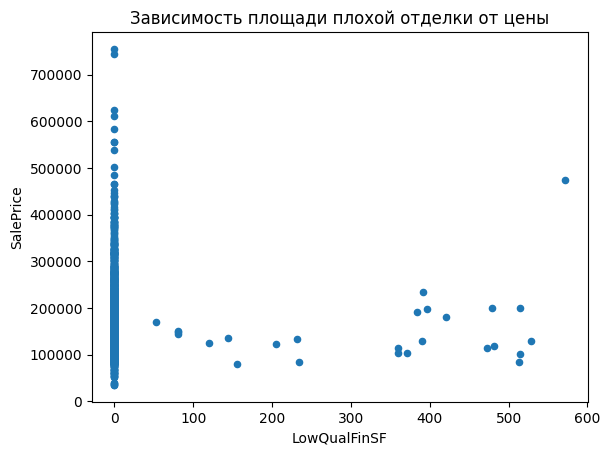

In [22]:
title = 'Зависимость площади плохой отделки от цены'
df_train.plot(kind='scatter', x='LowQualFinSF', y='SalePrice', title=title);

Видим, что при наличии отделки низкого качества (LowQualFinSF) цена не поднимается выше определенного порога, поэтому этот признак тоже бинаризую.

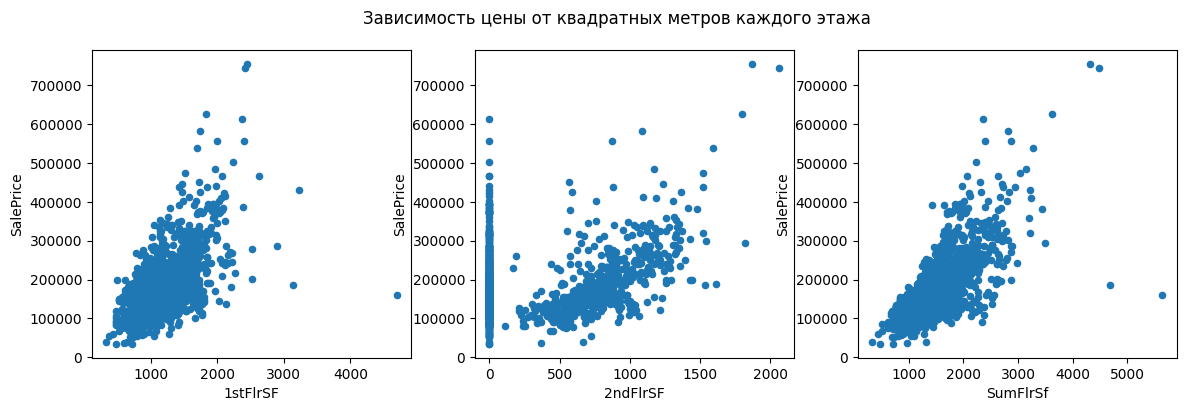

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))
fig.suptitle('Зависимость цены от квадратных метров каждого этажа')

df_train.plot(kind='scatter', x='1stFlrSF', y='SalePrice', ax=ax[0]);
df_train.plot(kind='scatter', x='2ndFlrSF', y='SalePrice', ax=ax[1]);
df_train['SumFlrSf'] = df_train['1stFlrSF'] + df_train['2ndFlrSF']
df_train.plot(kind='scatter', x='SumFlrSf', y='SalePrice', ax=ax[2]);

Наблюдаем, что при суммировании площадей обоих этажей сохраняется корреляция между целевой переменной и признаком, поэтому при препроцессинге сгенерирую новый признак – сумма площадей.

В датасете есть большое количество признаков, которые отвечают за качество того или иного элемента жилища. Переведу их в порядковые переменные (если тот или иной элемент отсутствует, то проставлю 0, в остальных случаях нумерация начнется с 1).

In [26]:
def QC_encoder(qual):
  qc = {
      'Po': 1,
      'Fa': 2,
      'TA': 3,
      'Gd': 4,
      'Ex': 5
  }

  if qual not in qc:
    return 0
  return qc[qual]

to_QC_encode = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual',
                'GarageCond']

Скорее всего, такое же кодирование будет использовано для этих признаков на этапе препроцессинга, несмотря на то, что предполагается использование методов, для которых кодирование категориальных признаков не столь важно.

Необходимость кодирования в данном случае обусловлена тем, что мы по сути имеем дело с порядковой переменной: от наихудшего качества к наилучшему.

In [27]:
df_train[to_QC_encode] = df_train[to_QC_encode].applymap(QC_encoder)

In [28]:
to_QC_encode = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual',
                'GarageCond']
QC = to_QC_encode + ['OverallQual', 'OverallCond', 'SalePrice']

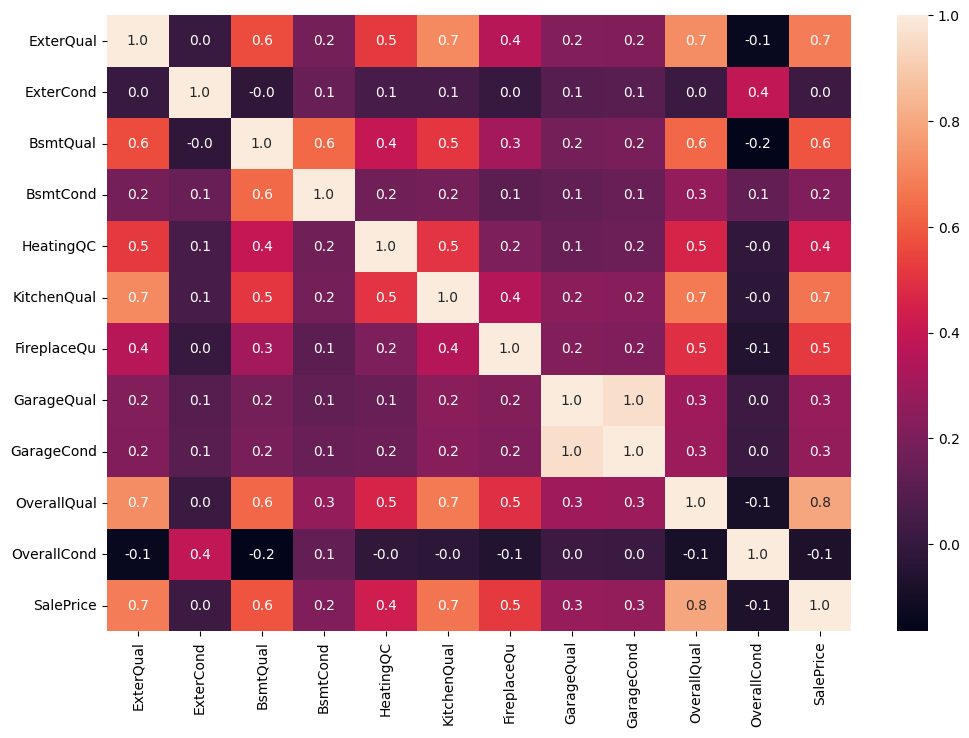

In [29]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_train[QC].corr(), annot=True, fmt='.1f');

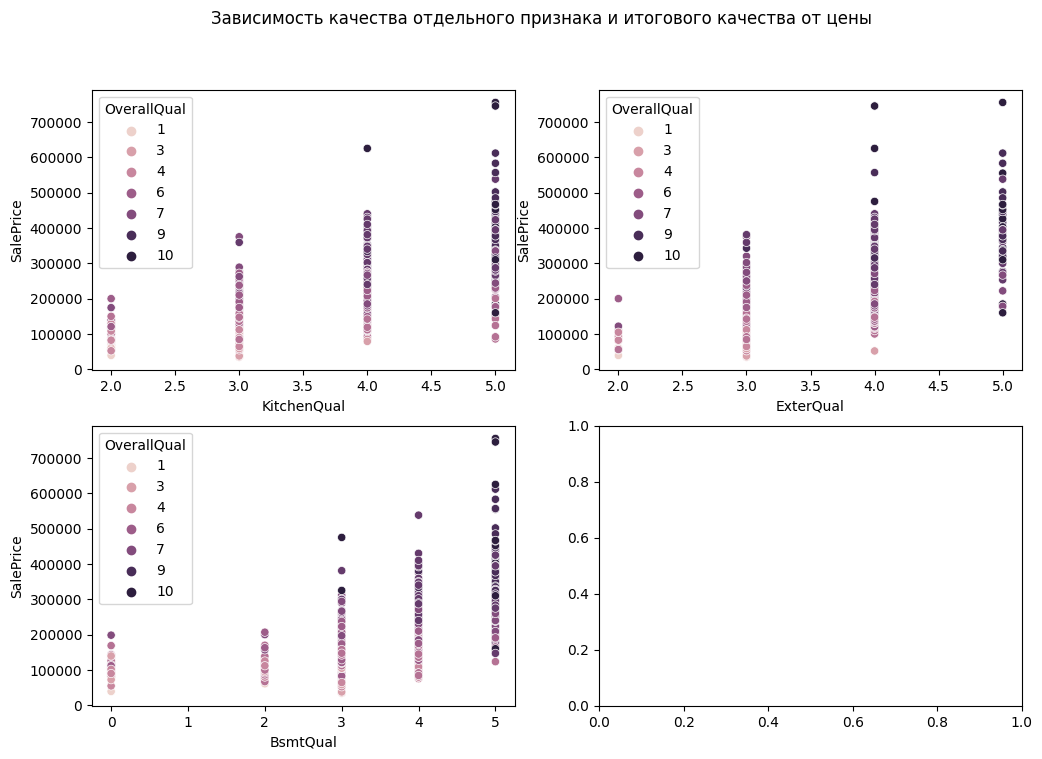

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Зависимость качества отдельного признака и итогового качества от цены')
sns.scatterplot(df_train, x='KitchenQual', y='SalePrice', hue='OverallQual', ax=axes[0, 0]);
sns.scatterplot(df_train, x='ExterQual', y='SalePrice', hue='OverallQual', ax=axes[0, 1]);
sns.scatterplot(df_train, x='BsmtQual', y='SalePrice', hue='OverallQual', ax=axes[1, 0]);

Удалю GarageCond из-за выраженной линейной зависимости с GarageQual.
Другие признаки оставлю, так как, несмотря на скоррелированность с OverallQual из графиков выше можно заметить, что цена зависит от значений качества отдельных элементов участка. Возможно, на этапе препроцессинга удалю скоррелированные оценки качества.

In [31]:
from sklearn.preprocessing import StandardScaler

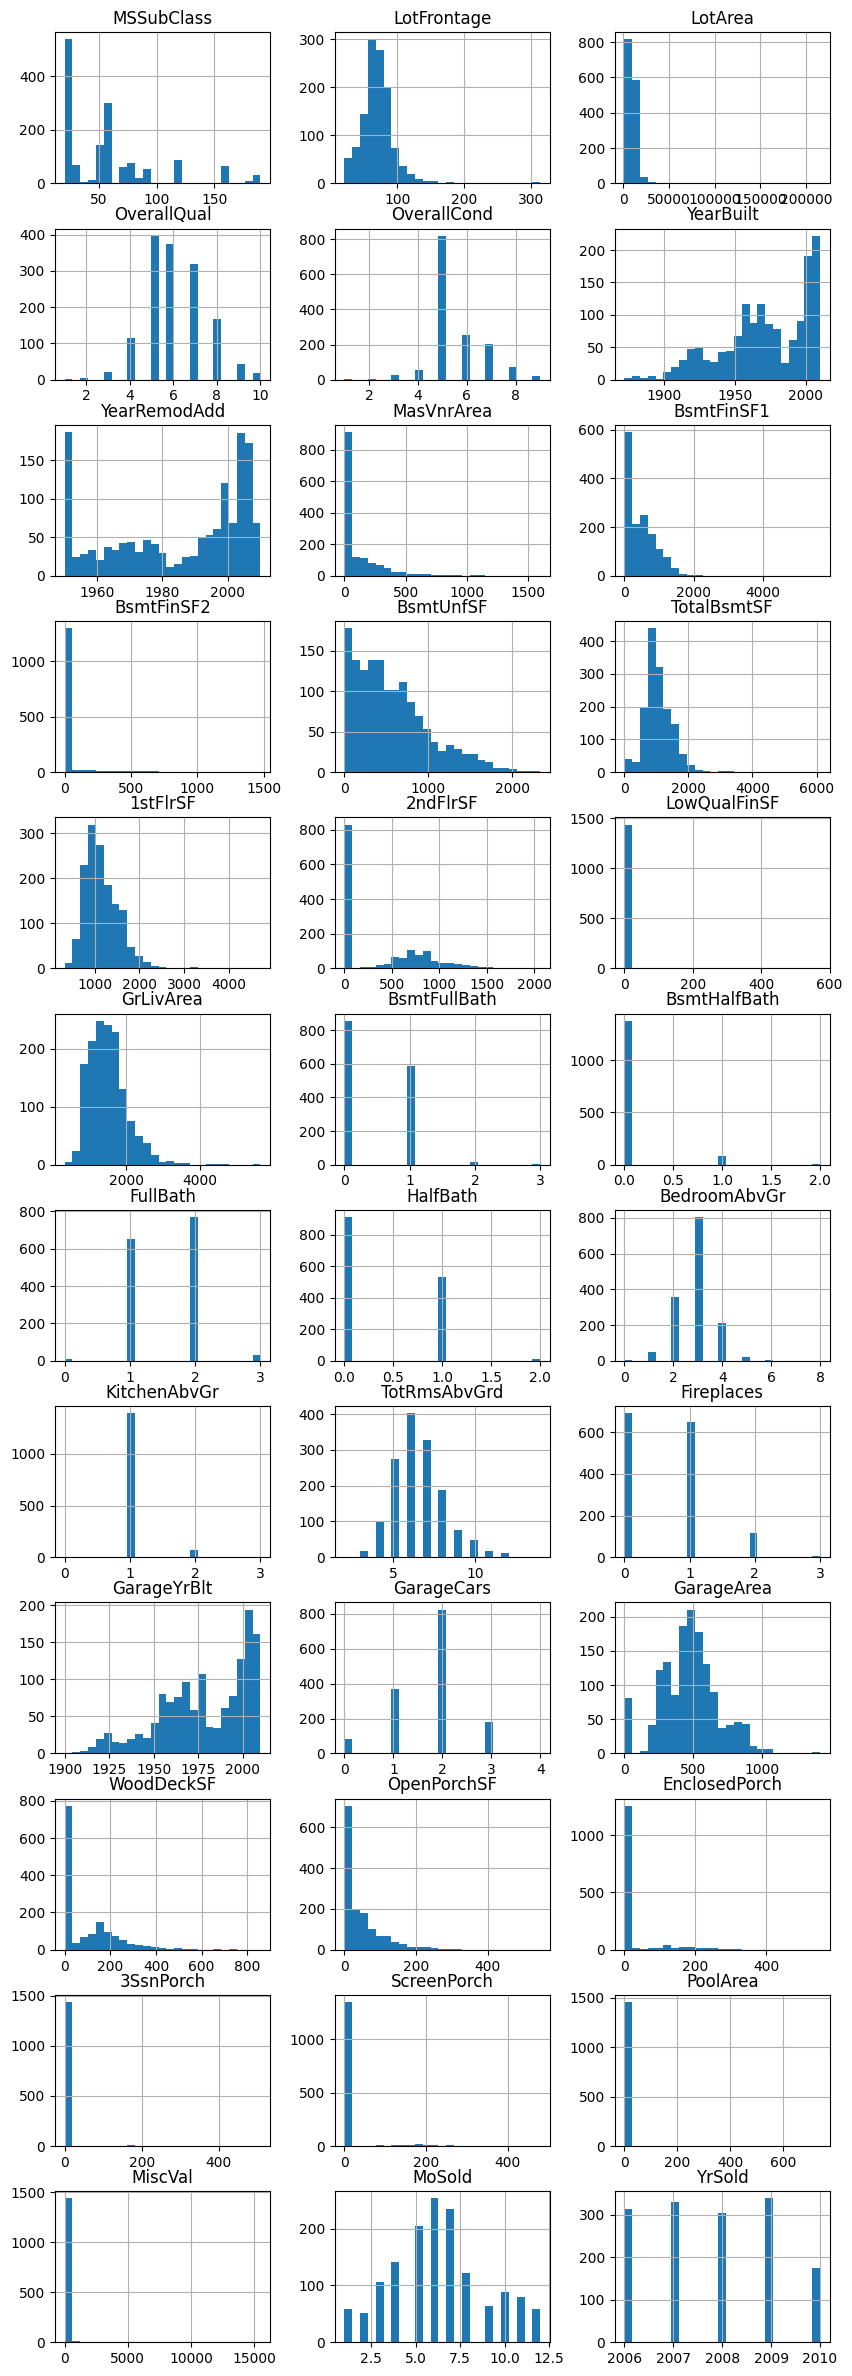

In [32]:
X.hist(bins=25, figsize=(10, 30), layout=(-1, 3));

Во многих признаках есть превалирующее значение – 0.
Для каждого из таких признаков стоит рассмотреть, стоит ли его выкидывать. Например, PoolArea лучше выкинуть, так как у нас уже есть категориальный признак, который отвечает за присутствие/отсутствие бассейна.

In [33]:
to_remove = ['PoolArea', 'MiscVal', 'BsmtFinSF2']
to_binarize = ['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'KitchenAbvGr']

Кроме того, на некоторых признаках заметны выбросы (огромная площадь буквально у единиц зданий).

In [34]:
X[X['LotArea'] > 50000].shape[0]

11

In [35]:
df_test[df_test['LotArea'] > 50000].shape[0]

3

Так как в тесте таких тоже объектов совсем мало, то из обучающей выборки такие огромные значения я тоже уберу, чтобы модель не подгонялась на очень редко встречающиеся объекты и показывала лучший результат на основной массе.

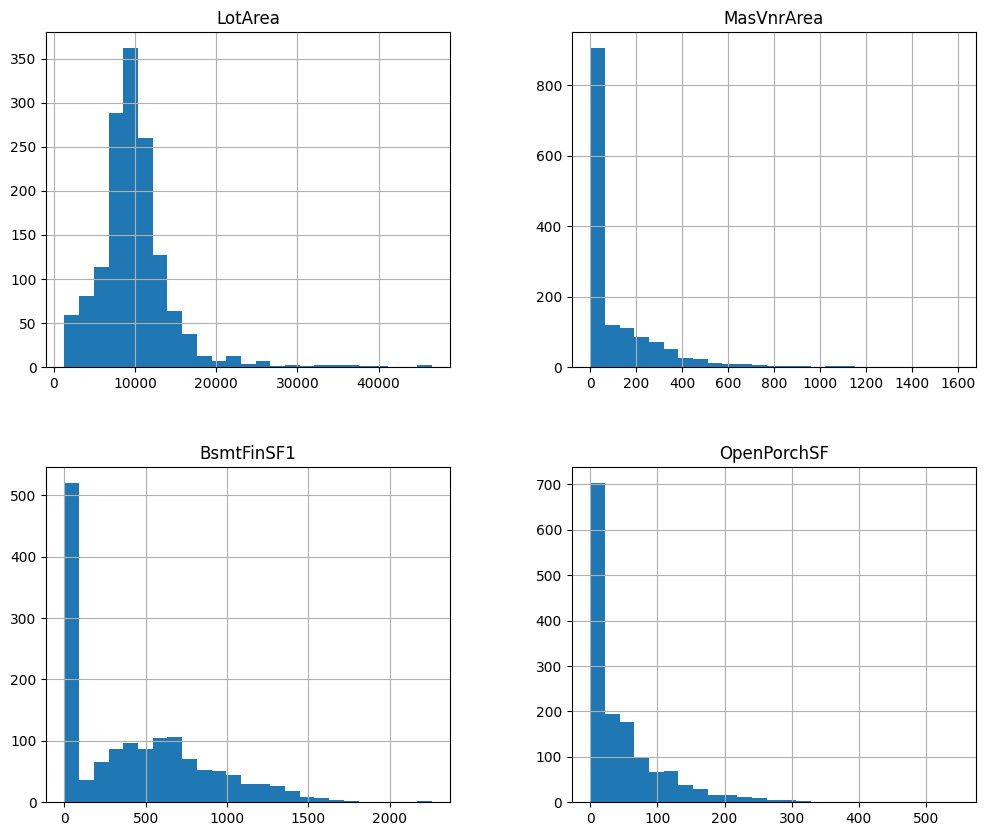

In [36]:
X[X['LotArea'] < 50000][['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'OpenPorchSF']].hist(bins=25, figsize=(12, 10), layout=(-1, 2));